In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import re
import time
import nltk
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn import tree
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import *
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import *
import sklearn.metrics as skm
from nltk.tokenize import TweetTokenizer
from emoji.unicode_codes import UNICODE_EMOJI
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from gensim.models import word2vec
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model


# A Classification Test of Sentiment of Tweets About Braziliam Presidential Elections

### Importing Data

In [27]:
data = pd.read_csv('../Data/dataset2018.tsv', header=0, delimiter='\t')

In [28]:
data.head(10)

,id,tweet,candidato,marcador,classe
0,twe977318071722442752,"@jangodurango ""Se eu soubesse que tu queria nã...",lula,alysson,Não sei
1,twe978104151359008769,Retweeted Florisvaldo Raimundo (@Florisrs): S...,lula,alysson,Não sei
2,twe984802485360582656,Ao invés dos petistas estarem buscando livrar ...,alckmin,alysson,Rejeição
3,twe977572021361168389,@CshmKnCaioHen @Peaotrabalhador @MiguelAMSA61 ...,manuela,alysson,Neutro
4,twe977558211447443457,"A pergunta é séria, @manudeputada: quer me pag...",manuela,alysson,Rejeição
5,twe977347407011897345,DISPARADO!!! 90%... https://t.co/f5G9063duC,bolsonaro,alysson,Neutro
6,twe984494027956543488,O que acontece agora que o inquérito de Alckmi...,alckmin,alysson,Neutro
7,twe981677295676084224,"- ""aécio é flagrado pedindo grana a empresário...",temer,alysson,Rejeição
8,twe978200570740822017,Se a bunda de algum ministro sentar sobre o pr...,lula,alysson,Rejeição
9,twe982682347484180482,"Hoje, não há lado certo ou lado errado. Lula é...",temer,alysson,Neutro


In [29]:
data = data[data['classe'] != 'Não sei']
data['classe'][data['classe'] == 'Rejeição'] = 'REJEICAO'
data['classe'][data['classe'] == 'Neutro'] = 'NEUTRO'
data['classe'][data['classe'] == 'Aprovação'] = 'APROVACAO'
data = data.dropna()
# data['classe'] = data['classe'].astype('int64')

In [30]:
# candidate_name = 'bolsonaro'

### Counting the number of tweets for each candidate

In [31]:
def count_tweets_per_candidate(data):
    counteds = set()
    counter_map = {}
    for i in range(len(data['candidato'])):
        if data['candidato'].iloc[i] not in counteds:
            candidate_name = data['candidato'].iloc[i]
            counter_map[candidate_name] = len(data[data['candidato'] == candidate_name])
            counteds.add(candidate_name)
    return counter_map

In [32]:
counter_map = count_tweets_per_candidate(data)

In [33]:
counter_map

{'alckmin': 158,
 'bolsonaro': 137,
 'ciro': 130,
 'lula': 133,
 'manuela': 156,
 'marina': 163,
 'temer': 128}

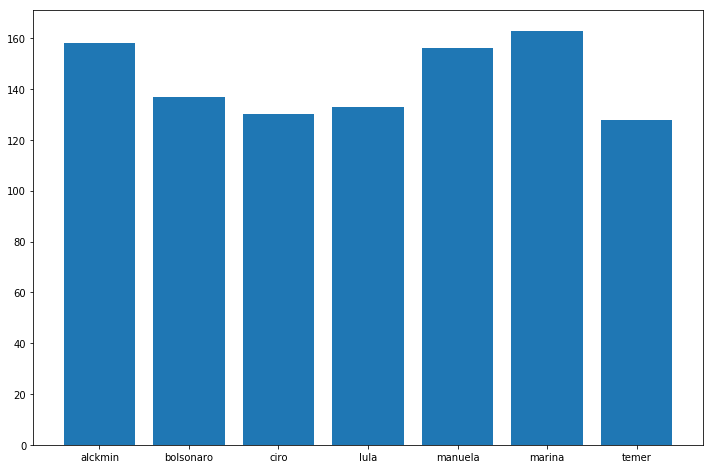

In [34]:
xLabels = list(counter_map.keys())
yValues = np.array(list(counter_map.values()))
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (12,8)
plt.bar(xLabels, yValues)
#plt.xticks(rotation='vertical')
plt.show()

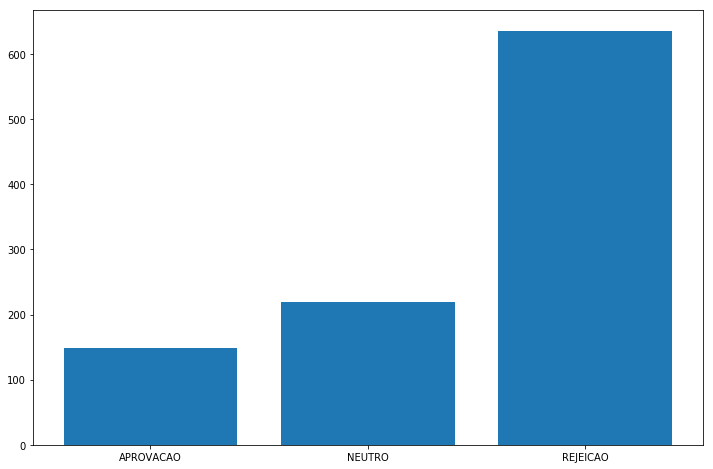

In [35]:
xLabels = list(data['classe'].value_counts().keys())
yValues = list(data['classe'].value_counts())
fig, ax = plt.subplots()
plt.bar(xLabels, yValues)
plt.show()

### Pre-processing tweets

In [36]:
def preProcessing(twitterText):
    #Remover \n
    twitterText = re.sub("\n+"," ",twitterText)

    #Remover multiplos espaços
    twitterText = re.sub(" +"," ",twitterText)
    
    #(@usuário) pelo termo ’AT_USER’ tal como sugerido em [Almatrafi et al., 2015].
    twitterText = re.sub("@\w+","atuser",twitterText)

    #Remove links
    twitterText = re.sub(r"http\S+", "",twitterText)

    #Remover caracteres especiais
    twitterText = re.sub("[@|#|“|”|’|‘|®|,|!|?||\[|\]|\.|\"|%|:|\-|_|/|ª|\(|\)|°|\*|🇧|🇷|\'|️|=]",'',twitterText)

    #Remover números
    twitterText = re.sub("[0-9]+",'',twitterText)

    #Tokenize
    twitterTokens = TweetTokenizer().tokenize(twitterText)

    #transforme emojis em textcode
    twitterTokensEmojisCode = []
    for token in twitterTokens:
        if(token in UNICODE_EMOJI):
            twitterTokensEmojisCode.append(UNICODE_EMOJI[token])
        else:
            twitterTokensEmojisCode.append(token)
    twitterTokens = twitterTokensEmojisCode

    #remove stopwords
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords.remove("não")
    stopwords.remove("num")
    stops = set(stopwords)
    twitterTokens = [token for token in twitterTokens if token not in stops ]
    
    #Lower case
    twitterText = " ".join(twitterTokens)
    twitterText = twitterText.lower()

    return twitterText

In [37]:
data['tweet'] = data['tweet'].apply(lambda x : preProcessing(x))
new_data = open('dataset_novo2018.txt', 'w')
for tweet in data['tweet']:
    new_data.write(','.join(tweet.split()) + '\n')
new_data.close()        

In [13]:
data.head(10)

,id,tweet,candidato,marcador,classe
2,twe984802485360582656,Ao invés dos petistas estarem buscando livrar ...,alckmin,alysson,REJEICAO
3,twe977572021361168389,@CshmKnCaioHen @Peaotrabalhador @MiguelAMSA61 ...,manuela,alysson,NEUTRO
4,twe977558211447443457,"A pergunta é séria, @manudeputada: quer me pag...",manuela,alysson,REJEICAO
5,twe977347407011897345,DISPARADO!!! 90%... https://t.co/f5G9063duC,bolsonaro,alysson,NEUTRO
6,twe984494027956543488,O que acontece agora que o inquérito de Alckmi...,alckmin,alysson,NEUTRO
7,twe981677295676084224,"- ""aécio é flagrado pedindo grana a empresário...",temer,alysson,REJEICAO
8,twe978200570740822017,Se a bunda de algum ministro sentar sobre o pr...,lula,alysson,REJEICAO
9,twe982682347484180482,"Hoje, não há lado certo ou lado errado. Lula é...",temer,alysson,NEUTRO
10,twe984980191066849280,Decisões do STF e do STJ de encaminhar process...,alckmin,alysson,NEUTRO
11,twe983555366133944320,PARA OS QUE AINDA NÃO SABEM! A pré-candidata à...,marina,alysson,NEUTRO


# Text feature extraction

In [14]:
#Bag of words
def featureextractionBOW(X):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(X)
    #Redução de dimensionalidade Truncated SVD (PCA para matrizes espaças)
    svd = TruncatedSVD(n_components=300)
    X_truncated = svd.fit_transform(X)
    return X_truncated

#TFIDF
def featureextractionTFIDF(X):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(X)
    tfidf = TfidfTransformer()
    X = tfidf.fit_transform(X)
    #Redução de dimensionalidade Truncated SVD (PCA para matrizes espaças)
    svd = TruncatedSVD(n_components=300)
    X_truncated = svd.fit_transform(X)
    return X_truncated

class FeatureGeneratorMedia:
    def __init__(self, X, w2vmodel, num_features):
        self.X = X
        self.w2vmodel = w2vmodel
        self.num_features = num_features
        self.features_vec = None

    def gen_features_dataset(self):
        self.X = self.X.apply(lambda text: TweetTokenizer().tokenize(text) )
        X_array = []
        self.X.apply(lambda listText: X_array.append(self.make_features_vec(listText)) )
        
        return np.matrix(X_array)
        
    def make_features_vec(self, tweet):
        featureVec = np.zeros(self.num_features)
        nwords = 0.0
        index2word_set = set(self.w2vmodel.wv.index2word)
        for word in tweet:
            if word in index2word_set:
                featureVec = np.add(featureVec, self.w2vmodel[word])
                nwords += 1
        if nwords == 0.0:
            nwords = 1.0
        return np.divide(featureVec, nwords)

def featureextractionWord2VecMean(X):
    num_features=300
    model = word2vec.Word2Vec.load("tweets_presidential_elections_min1_cont2_cbow")
    featureGeneratorMedia = FeatureGeneratorMedia(X,model,num_features)
    return featureGeneratorMedia.gen_features_dataset()
    

    

# Apply feature extractions and models

In [15]:
X = data['tweet']
Y = data['classe']

featureExtractionList = [("BOW",featureextractionBOW),("TFIDF",featureextractionTFIDF),("W2Vmean",featureextractionWord2VecMean)]
modelsName = ["GaussianNB", "BernoulliNB", "DecisionTreeClassifier","RandomForestClassifier", "AdaBoostClassifier","Logistic","Perceptron"]
listModels = [GaussianNB(),BernoulliNB(),tree.DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),linear_model.LogisticRegression(C=1e5),linear_model.Perceptron(n_iter=1000)]

In [16]:
it = 1
for extractionName,funcFeatureExtraction in featureExtractionList:
    X_features = funcFeatureExtraction(X)
    
    # train test split (sempre mesmo split)
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.3, random_state=1)
    
    for nameModel,model in zip(modelsName,listModels):
        configuration = extractionName+"+"+nameModel
        print("Configuration # "+str(it)+": "+configuration)
        
        start_time =  time.time()
        #Treina modelo
        print("inicio treino")
        model.fit(X_train,Y_train)
        print("fim treino")
        #Submeter-se dados de treino ao modelo - Teste
        Y_pred = model.predict(X_test)
        #Avalia modelo
        metricsStr = classification_report(Y_test,Y_pred)
        print(metricsStr)
        #print(precision_recall_fscore_support(Y_test,Y_pred))
        timeexec = (time.time() - start_time)
        print("Time: ",timeexec)
        print("\n")
        
        
        
        it+=1
        

Configuration # 1: BOW+GaussianNB
inicio treino
fim treino
             precision    recall  f1-score   support

  APROVACAO       0.19      0.28      0.22        57
     NEUTRO       0.31      0.59      0.41       106
   REJEICAO       0.73      0.36      0.48       245

avg / total       0.55      0.41      0.43       408

(array([0.18604651, 0.31188119, 0.73333333]), array([0.28070175, 0.59433962, 0.35918367]), array([0.22377622, 0.40909091, 0.48219178]), array([ 57, 106, 245]))
Time:  0.023879289627075195


Configuration # 2: BOW+BernoulliNB
inicio treino
fim treino
             precision    recall  f1-score   support

  APROVACAO       0.30      0.25      0.27        57
     NEUTRO       0.47      0.42      0.44       106
   REJEICAO       0.71      0.78      0.74       245

avg / total       0.59      0.61      0.60       408

(array([0.29787234, 0.46808511, 0.71161049]), array([0.24561404, 0.41509434, 0.7755102 ]), array([0.26923077, 0.44      , 0.7421875 ]), array([ 57, 106, 24

/home/romulo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fim treino
             precision    recall  f1-score   support

  APROVACAO       0.37      0.35      0.36        57
     NEUTRO       0.47      0.59      0.52       106
   REJEICAO       0.79      0.71      0.75       245

avg / total       0.65      0.63      0.63       408

(array([0.37037037, 0.46666667, 0.78995434]), array([0.35087719, 0.59433962, 0.70612245]), array([0.36036036, 0.52282158, 0.74568966]), array([ 57, 106, 245]))
Time:  1.5003635883331299


Configuration # 8: TFIDF+GaussianNB
inicio treino
fim treino
             precision    recall  f1-score   support

  APROVACAO       0.14      0.28      0.19        57
     NEUTRO       0.34      0.50      0.41       106
   REJEICAO       0.74      0.43      0.54       245

avg / total       0.56      0.43      0.46       408

(array([0.14159292, 0.34415584, 0.74468085]), array([0.28070175, 0.5       , 0.42857143]), array([0.18823529, 0.40769231, 0.54404145]), array([ 57, 106, 245]))
Time:  0.0162506103515625


Configuration # 

/home/romulo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fim treino
             precision    recall  f1-score   support

  APROVACAO       0.45      0.51      0.48        57
     NEUTRO       0.51      0.54      0.53       106
   REJEICAO       0.79      0.75      0.77       245

avg / total       0.67      0.66      0.66       408

(array([0.44615385, 0.51351351, 0.7887931 ]), array([0.50877193, 0.53773585, 0.74693878]), array([0.47540984, 0.52534562, 0.7672956 ]), array([ 57, 106, 245]))
Time:  1.488253116607666




/home/romulo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Configuration # 15: W2Vmean+GaussianNB
inicio treino
fim treino
             precision    recall  f1-score   support

  APROVACAO       0.31      0.26      0.29        57
     NEUTRO       0.56      0.29      0.39       106
   REJEICAO       0.67      0.84      0.75       245

avg / total       0.59      0.62      0.59       408

(array([0.3125    , 0.56363636, 0.67213115]), array([0.26315789, 0.29245283, 0.83673469]), array([0.28571429, 0.38509317, 0.74545455]), array([ 57, 106, 245]))
Time:  0.012186050415039062


Configuration # 16: W2Vmean+BernoulliNB
inicio treino
fim treino
             precision    recall  f1-score   support

  APROVACAO       0.28      0.18      0.22        57
     NEUTRO       0.55      0.38      0.45       106
   REJEICAO       0.69      0.84      0.76       245

avg / total       0.60      0.63      0.60       408

(array([0.27777778, 0.54794521, 0.69230769]), array([0.1754386 , 0.37735849, 0.84489796]), array([0.21505376, 0.44692737, 0.76102941]), array([ 5

/home/romulo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fim treino
             precision    recall  f1-score   support

  APROVACAO       0.23      0.65      0.34        57
     NEUTRO       0.51      0.17      0.26       106
   REJEICAO       0.81      0.70      0.75       245

avg / total       0.65      0.56      0.56       408

(array([0.23125   , 0.51428571, 0.80751174]), array([0.64912281, 0.16981132, 0.70204082]), array([0.34101382, 0.25531915, 0.7510917 ]), array([ 57, 106, 245]))
Time:  1.515993595123291


